## ML prediccion de emisiones de co2

In [19]:
#Librerias a usar

import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [20]:
#Cargamos la data 

data1a='electric_cars_limpio.csv'
data2a='fuel_vehicles_limpio.csv'
dataa3='hybrid_vehicle_limpio.csv'

In [21]:
#Creamos dfs 
electric_emissions=pd.read_csv(data1a)
fuel_emissions=pd.read_csv(data2a)
hybrid_emissions=pd.read_csv(dataa3)

In [22]:
#Estandarizamos las columnas que vamos a usar esto nos va ayudar a concatenar 
electric_emissions = electric_emissions.rename(columns={'vehicle_code':'vehicle code','model':'make','fuel_type': 'fuel_type','emisiones_CO2_g_per_km': 'emissions_co2_g_per_km','power_kw': 'engine_power_kw',
    'electric_range_km': 'electric_range_km','year':'registration year'})
hybrid_emissions = hybrid_emissions.rename(columns={'fuel type': 'fuel_type','emissions co2 g/km (wltp)': 'emissions_co2_g_per_km',
    'engine power (kw)': 'engine_power_kw',
    'electric range (km)': 'electric_range_km',
    })
fuel_emissions = fuel_emissions.rename(columns={'fuel type': 'fuel_type','emissions co2 g/km (wltp)': 'emissions_co2_g_per_km',
    'engine power (kw)': 'engine_power_kw',
    })

In [23]:
#Seleccionamos las columnas que vamos a utilizar 
electriccolumns=['identifier','manufacturer','make','fuel_type', 'emissions_co2_g_per_km', 
                   'energy_consumption_wh_per_km', 'engine_power_kw', 'electric_range_km', 'registration year']
fuelcolumns=['identifier','manufacturer', 'make', 'fuel_type', 'emissions_co2_g_per_km', 
                    'engine_power_kw', 'registration year','fuel consumption']

hybridcolumns=['identifier','manufacturer', 'make', 'fuel_type', 'emissions_co2_g_per_km','energy_consumption_wh_per_km', 
                    'engine_power_kw', 'electric_range_km','registration year','fuel consumption']

In [24]:
#Creamos data sets limpios 
electric_emissions_clean = electric_emissions[electriccolumns]
fuel_emissions_clean = fuel_emissions[fuelcolumns]
hybrid_emissions_clean = hybrid_emissions[hybridcolumns]

In [25]:
#Concatenamos 
combined_emissions = pd.concat([hybrid_emissions_clean, fuel_emissions_clean, electric_emissions_clean])

In [26]:
#Remplzamos nulos por 0 y quitamos duplicados 
combined_emissions=combined_emissions.fillna(0)
combined_emissions = combined_emissions.drop_duplicates()

In [27]:
#Exportamos el data set limpio a csv para poder usarlo en big query o en cualquier otra plataforma si es necesario 
combined_emissions.to_csv('combined_emissions_clean.csv', index=False)

In [28]:
#Lo volvemos a cargar para el modelo este paso lo podemos evitar si seguimos usando solo un script si ese fuera el caso seguimos trabajando con combined_emissions 

df = pd.read_csv('combined_emissions_clean.csv')

In [29]:
#Como tenemos una variable categorica usamos dummies para poder usarla con valores numéricos y que el modelo los pueda usar 
df = pd.get_dummies(df, columns=['fuel_type'], drop_first=True)

In [30]:
#Dividimos nuestras variables en dependientees e independientes 
X = df[['engine_power_kw', 'energy_consumption_wh_per_km', 'electric_range_km', 'registration year'] + [col for col in df if col.startswith('fuel_type_')]]
y = df['emissions_co2_g_per_km']

In [31]:
#Dividimos nuestros registros para el entrenamiento y el testeo y anclamos la seed para que no haya variaciones al correrlo en diferentes momentos 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [32]:
#Realizamos el modelo 
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

In [33]:
#Vemos las métricas de MSE y R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, R²: {r2}')

MSE: 575.8864604686372, R²: 0.8399509995840029


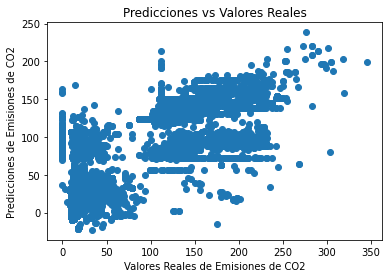

In [34]:
#Graficamos la distribucion de las predicciones vs los valores reales 
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales de Emisiones de CO2')
plt.ylabel('Predicciones de Emisiones de CO2')
plt.title('Predicciones vs Valores Reales')
plt.show()

In [39]:
#Creamos un diccionario para hacer un df y poder predecir con valores nuevos 
nuevo_vehiculo = {
    'engine_power_kw': 91,
    'energy_consumption_wh_per_km': 0,
    'electric_range_km': 0,
    'registration year': 2023,
    'fuel_type_diesel/electric': 0,
    'fuel_type_e85': 1,
    'fuel_type_electric': 0,
    'fuel_type_petrol':0,
    'fuel_type_petrol/electric':0}
prediccion = pd.DataFrame([nuevo_vehiculo])

In [40]:
#Realizamos nuevas predicciones en este caso en específico usamos valores del conjunto del testeo para oder observa como varia con el valor real 
prediccion_emisiones = model_lr.predict(prediccion)
print(f'Predicción de emisiones de CO2: {prediccion_emisiones[0]} g/km')

Predicción de emisiones de CO2: 124.6613896928491 g/km


In [37]:
#Creamos un df que nos de esta info del conjunto de testeo 
test_data=X_test.copy()
test_data['emissions_co2_g_per_km'] = y_test

In [38]:
#Observamos los valores  y vemos que hay una vaeriacion de +3.6 g/km en las emisiones de co2 un valor muy aceptable de predicción por lo que concluimos que el modelo es adecuado y funciona bien 
test_data.head()

,engine_power_kw,energy_consumption_wh_per_km,electric_range_km,registration year,fuel_type_diesel/electric,fuel_type_e85,fuel_type_electric,fuel_type_petrol,fuel_type_petrol/electric,emissions_co2_g_per_km
141880,91.0,0.0,0.0,2023,False,True,False,False,False,121.000000
102314,96.0,0.0,0.0,2023,False,False,False,True,False,149.000000
112176,116.0,0.0,0.0,2023,False,False,False,True,False,122.000000
1473,136.0,214.0,70.0,2023,False,False,False,False,True,25.000000
182364,150.0,169.0,520.0,2023,False,False,True,False,False,10.891111
